# Predicting delays

The next area of investigation focussed on predicting the likelihood that a ship would be delayed and arrive at its intended destination sometime after its estimated time of arrival. The objective of this study was not to develop an optimal model that could be used in a practical sense to predict delays, instead development followed a proof-of concept approach, where the capability to predict delays was demonstrated and the various features of the prediction identified.

In [1]:
# base libraries
import pandas as pd
import math
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# set variable from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
features_filename = config['DEFAULT']['features_filename']

In [4]:
all_features = pd.read_csv(processing_path + features_filename,header = 0,delimiter = ',')
all_features['dt'] = pd.to_datetime(all_features['dt'])
all_features['ETA_new'] = pd.to_datetime(all_features['ETA_new'])
all_features['ETA'] = pd.to_datetime(all_features['ETA'])

In [5]:
# only keep records before the ship arrives
dev_data = all_features[all_features.dt <= all_features.ETA].copy()

In [6]:
# convert string fields about hazmat to boolean
dev_data['in_hazmat'] = dev_data['in_hazmat'].map({'Yes':1,'No':0})
dev_data['out_hazmat'] = dev_data['out_hazmat'].map({'Yes':1,'No':0})

In [7]:
# Check for nulls and replace with 0 where appropriate
dev_data.isnull().sum()
dev_data['accel'].fillna(0,inplace = True)
dev_data['previous_delays'].fillna(0,inplace = True)
dev_data['seg_Docked'].fillna(0,inplace = True)
dev_data['seg_Trans_general'].fillna(0,inplace = True)
dev_data['seg_Docking_inital'].fillna(0,inplace = True)
dev_data['seg_Docking_terminal'].fillna(0,inplace = True)
dev_data['seg_Docking_mid'].fillna(0,inplace = True)
dev_data['seg_Trans_border'].fillna(0,inplace = True)
dev_data['port_dist'].fillna(-1,inplace = True)
dev_data['sea_lev_pressure'].fillna(0,inplace = True)
dev_data['visibility'].fillna(0,inplace = True)
dev_data['wind_speed'].fillna(0,inplace = True)
dev_data['max_temp'].fillna(0,inplace = True)
dev_data['min_temp'].fillna(99,inplace = True)

# check for INFs and replace with 0 where appropriate
dev_data.replace([np.inf, -np.inf],np.nan,inplace = True)

To mitigate the effects of extreme (large or small) delay rates and to compare predictive performance across models predicting the five different delay definitions (15, 30, 60, 90 and 120 mins), the development samples are balanced to contain equal numbers of delayed and non-delayed ships. A 20% test dataset  randomly sampled and stratified on the target delayed field so that balanced outcomes were maintained within both training and test datasets. The test dataset is used to independently test the performance of each model. Training and test performance are compared to ensure overfitting is not present.

In [8]:
dev_data.drop(['MMSI','dt','YEARMODA','rot','SOG','ETA_new','ETA','POC_LOCODE','Type','tripid',
               'last_port_LOCODE','next_port_LOCODE','status','voyage_id','arrivalDelay','arrivalDelayMin',
                'start_window','end_window','count','vessel_name',
                'long','lat','station_pressure','dew_point','temp',
                'max_wind_speed','fog_rain_driz_snow_ice',
                'accel','HOD1','WOY1','MOY1','DOW1','MOH1', 'out_hazmat',
                'HOD2','WOY2','MOY2','DOW2','MOH2','WOY','MOY','MOH',
                'type_cargo_ship','type_container','type_general_cargo','type_unknown',
                'pl_seg_Docked','pl_seg_Docking_inital','pl_seg_Docking_mid',
                'pl_seg_Docking_terminal','pl_seg_Trans_border','pl_seg_Trans_general',
                'pl_type_container','pl_type_dredger','pl_type_general_cargo',
                'pl_type_passenger','pl_type_pilot','pl_type_sar','pl_type_unknown',
                'pl_type_work_vessel','previous_delays','seg_Docked','seg_Trans_border',
                'seg_Docking_terminal','seg_Trans_general','seg_Docking_mid','seg_Docking_inital'], 
              axis = 1, inplace = True)

In [9]:
# extract all the delayed records
dev_data_delayed = dev_data[dev_data['delay15'] == True]

# extract all the ontime records
dev_data_ontime = dev_data[dev_data['delay15'] == False]

# take a sample of the delayed records
dev_data_delayed_sample = dev_data_delayed.sample(len(dev_data_delayed),random_state = 1234,axis = 0)

# concatenate the two datasets
dev_data_balanced = pd.concat([dev_data_delayed_sample,dev_data_ontime])

# randomise the dataset
dev_data_balanced = dev_data_balanced.sample(len(dev_data_balanced),random_state = 1234,axis = 0)

In [10]:
target = dev_data_balanced[['delay15']]
features = dev_data_balanced.drop(['delay15','delay30','delay60','delay90','delay120'],axis=1)

In [11]:
# split into train and test (80:20), maintain the balanced sample
features_train,features_test,target_train,target_test = train_test_split(features,
                                                                         target,
                                                                         test_size = 0.2,
                                                                         random_state = 1234,
                                                                         stratify = target)

## Training
Several ensemble based machine learning classifiers are investigated including Random Forest, AdaBoost and Gradient Boosted Trees, the performance across all is broadly comparable. A slight performance increase is obtained with an XGBoost algorithm  using the default hyperparameters (maximum tree depth of two, 100 independent estimators and a learning rate of 0.05), this approach is used as the preferred approach. 

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# initialise the forest
delays_forest = RandomForestClassifier(n_estimators = 100,
                                       max_leaf_nodes = 16,
                                       n_jobs = -1,
                                       random_state = 1234)

# train the forest
delays_forest.fit(features_train, target_train['delay15'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [13]:
# get the train accuracy(correct prediction rate)
delays_forest.score(features_train,target_train)

0.7011598149483023

In [14]:
# get the training confusion matrix
# score the train data first
train_classified = delays_forest.predict(features_train)
train_prob = delays_forest.predict_proba(features_train)
confusion_matrix(target_train, train_classified)

array([[100868,  35590],
       [ 42765,  82974]])

In [15]:
# get the feature importance (decending order of importance)
# the importance of a feature is computed as the (normalized - sums to 1) total reduction of the criterion 
# brought by that feature. It is also known as the Gini importance [R251].
feature_importance = delays_forest.feature_importances_
feature_importance = pd.DataFrame(feature_importance,
                                  columns = ['feature_importance'])
feature_names = features_train.columns.values
feature_names = pd.DataFrame(feature_names,
                             columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                              feature_importance,
                              left_index = True,
                              right_index = True,
                              how = 'inner')
feature_importance.sort_values('feature_importance',
                               ascending = False,
                               inplace = True)
feature_importance

,feature_name,feature_importance
9,max_temp,0.230174
10,min_temp,0.124662
6,sea_lev_pressure,0.109673
0,gross_tonnage,0.109162
11,port_dist,0.105347
2,HOD,0.102861
7,visibility,0.094315
8,wind_speed,0.068012
4,pl_type_cargo_ship,0.027147
3,DOW,0.017240


In [16]:
delays_forest.score(features_test,target_test)

0.6987643020594966

### AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# initialise the classifier
delays_adabost = AdaBoostClassifier(n_estimators = 100, algorithm = 'SAMME.R', learning_rate = 0.5)

delays_adabost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1),
                                    n_estimators = 100,
                                    algorithm = 'SAMME.R',
                                    learning_rate = 0.5)

# train the AdaBost classifier
delays_adabost.fit(features_train, target_train['delay15'])

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=None)

In [18]:
delays_adabost.score(features_train,target_train)

0.6859994584224839

In [19]:
feature_importance = delays_adabost.feature_importances_
feature_importance = pd.DataFrame(feature_importance,
                                  columns = ['feature_importance'])
feature_names = features_train.columns.values
feature_names = pd.DataFrame(feature_names,
                             columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                              feature_importance,
                              left_index = True,
                              right_index = True,
                              how = 'inner')
feature_importance.sort_values('feature_importance',
                               ascending = False,
                               inplace = True)
feature_importance

,feature_name,feature_importance
0,gross_tonnage,0.25
2,HOD,0.16
8,wind_speed,0.14
6,sea_lev_pressure,0.12
7,visibility,0.11
10,min_temp,0.07
3,DOW,0.06
9,max_temp,0.04
11,port_dist,0.04
4,pl_type_cargo_ship,0.01


In [20]:
delays_adabost.score(features_test,target_test)

0.6848054919908467

### XGBoost

In [21]:
import xgboost as xgb
from xgboost import plot_tree

In [22]:
delays_xgboost = xgb.XGBClassifier(max_depth = 2,
                                   n_estimators = 100,
                                   learning_rate = 0.05)

In [23]:
# train the classifier
t_train = target_train.values.ravel()
t_test = target_test.values.ravel()
f_train = features_train.values
f_test = features_test.values
delays_xgboost.fit(f_train,t_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
delays_xgboost.score(f_train,t_train)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.689142133586578

In [25]:
feature_importance = delays_xgboost.feature_importances_
feature_importance = pd.DataFrame(feature_importance,
                                  columns = ['feature_importance'])

feature_names = features_train.columns.values
feature_names = pd.DataFrame(feature_names,
                             columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                              feature_importance,
                              left_index = True,
                              right_index = True,
                              how = 'inner')
feature_importance.sort_values('feature_importance',
                               ascending = False,
                               inplace = True)
feature_importance

,feature_name,feature_importance
2,HOD,0.183333
0,gross_tonnage,0.170000
11,port_dist,0.146667
6,sea_lev_pressure,0.130000
8,wind_speed,0.123333
7,visibility,0.103333
9,max_temp,0.073333
10,min_temp,0.053333
4,pl_type_cargo_ship,0.013333
3,DOW,0.003333


In [26]:
delays_xgboost.score(f_test,t_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6887261632341724

In [27]:
# get the test confusion matrix
# score the test data first
test_classified = delays_xgboost.predict(f_test)
test_prob = delays_xgboost.predict_proba(f_test)
confusion_matrix(t_test,test_classified)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[25934,  8181],
       [12223, 19212]])

## Different delay sizes

In [28]:
def train_test_delay(delay_mins):

     # extract all the delayed records
    delayed = dev_data[dev_data['delay'+str(delay_mins)] == True]

    # extract all the ontime records
    ontime = dev_data[dev_data['delay'+str(delay_mins)] == False]

    if len(ontime) > len(delayed):
        # take a sample of the ontime records
        ontime_sample = ontime.sample(len(delayed),random_state = 1234,axis = 0)
        # concatenate the two datasets
        balanced = pd.concat([delayed,ontime_sample])
    else:
        # take a sample of the delayed records
        delayed_sample = delayed.sample(len(ontime),random_state = 1234,axis = 0)
        # concatenate the two datasets
        balanced = pd.concat([delayed_sample,ontime])

    # randomise the dataset
    balanced = balanced.sample(len(balanced),random_state = 1234,axis = 0)

    target = balanced[['delay'+str(delay_mins)]]
    
    features = balanced.drop(['delay15','delay30','delay60','delay90','delay120'],axis=1)

    # split into train and test (80:20), maintain the balanced sample
    features_train,features_test,target_train,target_test = train_test_split(features,
                                                                             target,
                                                                             test_size = 0.2,
                                                                             random_state = 1234,
                                                                             stratify = target)
    return features_train,features_test,target_train,target_test

In [29]:
features_train15,features_test15,target_train15,target_test15 = train_test_delay(15)
features_train30,features_test30,target_train30,target_test30 = train_test_delay(30)
features_train60,features_test60,target_train60,target_test60 = train_test_delay(60)
features_train90,features_test90,target_train90,target_test90 = train_test_delay(90)
features_train120,features_test120,target_train120,target_test120 = train_test_delay(120)

In [30]:
train_test_lengths = [('15_minutes',len(target_train15),len(target_test15)),
                      ('30 minutes', len(target_train30),len(target_test30)),
                      ('60 minutes', len(target_train60),len(target_test60)),
                      ('90 minutes', len(target_train90),len(target_test90)),
                      ('120 minutes', len(target_train120),len(target_test120))]
                      
train_test_lengths = pd.DataFrame(train_test_lengths)
train_test_lengths.columns = ['Delay Threshold','Training','Test']

Training and test dataset sizes. A delay threshold of 15 minutes indicates that a ship is deemed as being delayed if it arrives 15 minutes after its estimated arrival time

### Training

To explore the relationship between model performance and delay time, an XGBoost model is trained on each of the target fields

In [31]:
def xg_boost_delays(features_train,features_test,target_train,target_test):
    #Train the classifier
    t_train = target_train.values.ravel()
    t_test = target_test.values.ravel()
    f_train = features_train.values
    f_test = features_test.values
    delays_xgboost.fit(f_train,t_train)

    return [delays_xgboost.score(f_train,t_train),delays_xgboost.score(f_test,t_test)]

In [32]:
delay15_scores = xg_boost_delays(features_train15,features_test15,target_train15,target_test15)
delay30_scores = xg_boost_delays(features_train30,features_test30,target_train30,target_test30)
delay60_scores = xg_boost_delays(features_train60,features_test60,target_train60,target_test60)
delay90_scores = xg_boost_delays(features_train90,features_test90,target_train90,target_test90)
delay120_scores = xg_boost_delays(features_train120,features_test120,target_train120,target_test120)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [33]:
training = [delay15_scores[0],delay30_scores[0],delay60_scores[0],delay90_scores[0],delay120_scores[0]]
test = [delay15_scores[1],delay30_scores[1],delay60_scores[1],delay90_scores[1],delay120_scores[1]]

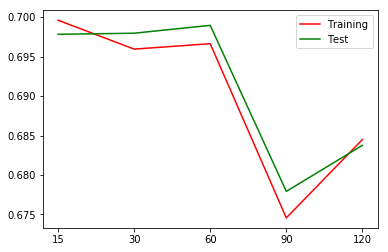

In [34]:
x = [15,30,60,90,120]
xi = [i for i in range(0, len(x))]
plt.plot(xi, training, color = 'r', label = 'Training')
plt.plot(xi, test, color = 'g', label = 'Test')
plt.xticks(xi, x)
plt.legend()
plt.show()